In [ ]:
# !pip install pandas
# !pip install albumentations
# !pip install rich

In [16]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import glob
from rich import print
from ipywidgets import interact
from tqdm.auto import tqdm
import albumentations as A

SIZE=(384,384)

In [17]:
df_train = pd.read_csv("/root/train_fix.csv")
df_train = df_train.sort_values(["id", "class"]).reset_index(drop = True)
df_train["patient"] = df_train.id.apply(lambda x: x.split("_")[0])
df_train["days"] = df_train.id.apply(lambda x: "_".join(x.split("_")[:2]))
num_slices = len(np.unique(df_train.id))
num_empty_slices = df_train.groupby("id").apply(lambda x: x.segmentation.isna().all()).sum()
num_patients = len(np.unique(df_train.patient))
num_days = len(np.unique(df_train.days))
print({
    "#slices:": num_slices,
    "#empty slices:": num_empty_slices,
    "#patients": num_patients,
    "#days": num_days
})

{'#slices:': 38496, '#empty slices:': 21900, '#patients': 85, '#days': 274}

In [18]:
all_image_files = sorted(glob.glob("/root/data/train/*/*/scans/*.png"), key = lambda x: x.split("/")[5] + "_" + x.split("/")[7])
size_x = [int(os.path.basename(_)[:-4].split("_")[-4]) for _ in all_image_files]
size_y = [int(os.path.basename(_)[:-4].split("_")[-3]) for _ in all_image_files]
spacing_x = [float(os.path.basename(_)[:-4].split("_")[-2]) for _ in all_image_files]
spacing_y = [float(os.path.basename(_)[:-4].split("_")[-1]) for _ in all_image_files]
df_train["image_files"] = np.repeat(all_image_files, 3)
df_train["spacing_x"] = np.repeat(spacing_x, 3)
df_train["spacing_y"] = np.repeat(spacing_y, 3)
df_train["size_x"] = np.repeat(size_x, 3)
df_train["size_y"] = np.repeat(size_y, 3)
df_train["slice"] = np.repeat([int(os.path.basename(_)[:-4].split("_")[-5]) for _ in all_image_files], 3)
df_train

,id,class,segmentation,patient,days,image_files,spacing_x,spacing_y,size_x,size_y,slice
0,case101_day20_slice_0001,large_bowel,NaN,case101,case101_day20,/root/data/train/case101/case101_day20/scans/s...,1.5,1.5,266,266,1
1,case101_day20_slice_0001,small_bowel,NaN,case101,case101_day20,/root/data/train/case101/case101_day20/scans/s...,1.5,1.5,266,266,1
2,case101_day20_slice_0001,stomach,NaN,case101,case101_day20,/root/data/train/case101/case101_day20/scans/s...,1.5,1.5,266,266,1
3,case101_day20_slice_0002,large_bowel,NaN,case101,case101_day20,/root/data/train/case101/case101_day20/scans/s...,1.5,1.5,266,266,2
4,case101_day20_slice_0002,small_bowel,NaN,case101,case101_day20,/root/data/train/case101/case101_day20/scans/s...,1.5,1.5,266,266,2
...,...,...,...,...,...,...,...,...,...,...,...
115483,case9_day22_slice_0143,small_bowel,NaN,case9,case9_day22,/root/data/train/case9/case9_day22/scans/slice...,1.5,1.5,360,310,143
115484,case9_day22_slice_0143,stomach,NaN,case9,case9_day22,/root/data/train/case9/case9_day22/scans/slice...,1.5,1.5,360,310,143
115485,case9_day22_slice_0144,large_bowel,NaN,case9,case9_day22,/root/data/train/case9/case9_day22/scans/slice...,1.5,1.5,360,310,144
115486,case9_day22_slice_0144,small_bowel,NaN,case9,case9_day22,/root/data/train/case9/case9_day22/scans/slice...,1.5,1.5,360,310,144


### Remove Incorrect Annos

In [ ]:
# '''
# Case 7 day 0: mix
# Case 43 day 18: few more large-bowel
# Case 43 day 26: large-bowel miss
# Case 81 day 0: mix
# Case 138 day 0: flash large-bowel
# '''
# from tqdm.notebook import tqdm
# Case138_Day0 = [i for i in range(76,145)]
# Case85_Day23 = [119,120,121,122,123,124]
# Case90_Day29 = [115,116,117,118,119]
# Case133_Day25 = [111,112,113]
# df = df_train.copy()
# Case7 = []
# Case43 = []
# Case81 = []
# Case85 = []
# Case90 = []
# Case133 = []
# Case138 = []
# for i,row in tqdm(df_train.iterrows(), total=len(df_train)):
#     if row.id.rsplit("_",2)[0]=='case7_day0':
#         Case7.append(i)
#     elif row.id.rsplit("_",2)[0]=='case43_day18' or row.id.rsplit("_",2)[0]=='case43_day26':
#         Case43.append(i)
#     elif row.id.rsplit("_",2)[0]=='case81_day30':
#         Case81.append(i)
#     elif row.id.rsplit("_",2)[0]=='case138_day0':
#         if int(row.id.rsplit("_",1)[-1]) in Case138_Day0:
#             Case138.append(i)
# print(len(Case7),len(Case43),len(Case138))
# df_train.drop(index=Case7+Case43+Case81+Case138 ,inplace=True)
# df_train = df_train.reset_index(drop=True)

In [19]:
from tqdm.notebook import tqdm
channels=3
strides=[6,0,-6]
for i in range(channels):
    df_train[f'image_path_{i:02}'] = df_train.groupby(['days'])['image_files'].shift(strides[i])#.fillna(method="ffill")
df_train['image_paths'] = df_train[[f'image_path_{i:02d}' for i in range(channels)]].values.tolist()
print(len(df_train))
for i,row in tqdm(df_train.iterrows(), total=len(df_train)):
    if type(row.image_paths[0]) == float:
        df_train.iloc[i].image_paths[0] = df_train.iloc[i].image_paths[1]
    if type(row.image_paths[-1]) == float:
        df_train.iloc[i].image_paths[-1] = df_train.iloc[i].image_paths[1]
df_train.image_paths[434]

115488

  0%|          | 0/115488 [00:00<?, ?it/s]

['/root/data/train/case101/case101_day22/scans/slice_0001_266_266_1.50_1.50.png',
 '/root/data/train/case101/case101_day22/scans/slice_0001_266_266_1.50_1.50.png',
 '/root/data/train/case101/case101_day22/scans/slice_0003_266_266_1.50_1.50.png']

In [20]:
def rle_decode(mask_rle, old_shape, new_shape):
    s = np.array(mask_rle.split(), dtype=int)
    starts, lengths = s[0::2] - 1, s[1::2]
    ends = starts + lengths
    h, w = old_shape
    mask = np.zeros((h * w,), dtype = np.uint8)
    for lo, hi in zip(starts, ends):
        mask[lo : hi] = 1
    mask = mask.reshape(old_shape)
    return mask
def load_img(path, new_shape=(320,320)):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    old_shape = img.shape
    return img, old_shape
def rescale(img, masks, old_shape, new_shape):
    if old_shape==(234,234):
        img = cv2.resize(img,new_shape,interpolation=cv2.INTER_NEAREST)
        masks = cv2.resize(masks,new_shape,interpolation=cv2.INTER_NEAREST)
    if old_shape==(266,266):
        img = cv2.resize(img,new_shape,interpolation=cv2.INTER_NEAREST)
        masks = cv2.resize(masks,new_shape,interpolation=cv2.INTER_NEAREST)
    if old_shape==(276,276):
        img = cv2.resize(img,new_shape,interpolation=cv2.INTER_NEAREST)
        masks = cv2.resize(masks,new_shape,interpolation=cv2.INTER_NEAREST)
    if old_shape==(310,360):
        img = np.pad(img,((25,25),(0,0),(0,0)),'constant')
        masks = np.pad(masks,((25,25),(0,0),(0,0)),'constant')
        img = cv2.resize(img,new_shape,interpolation=cv2.INTER_NEAREST)
        masks = cv2.resize(masks,new_shape,interpolation=cv2.INTER_NEAREST)
    return img, masks

def display_pre(file_name, new_shape=(320,320)):
    norm = lambda x: (x / np.ptp(x) * 255).astype(np.uint8)
    segms = df_train.loc[df_train.image_files == file_name]
    ori_shape = (segms.size_y.iloc[0], segms.size_x.iloc[0])
    img_paths = segms.image_paths.iloc[0]
    img = np.zeros((*ori_shape, len(img_paths)), dtype=np.uint16)
    for i, img_path in enumerate(img_paths):
        image,old_shape = load_img(img_path, new_shape)
        img[..., i]+=image
    img = norm(img)
    masks = img.copy().astype(np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = segms[segms['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            masks[..., i] = masks[...,i]/2+rle_decode(rle, old_shape, new_shape)*127
    img, masks = rescale(img, masks, old_shape, new_shape)
    img = np.concatenate([img, np.ones((img.shape[0], 10, 3), dtype = np.uint8) * 255, masks], 1)
    return img

size_x  size_y  spacing_x  spacing_y
266     266     1.50       1.50         77760
360     310     1.50       1.50         33696
276     276     1.63       1.63          3600
234     234     1.50       1.50           432
dtype: int64

(234, 234, 1.5, 1.5)

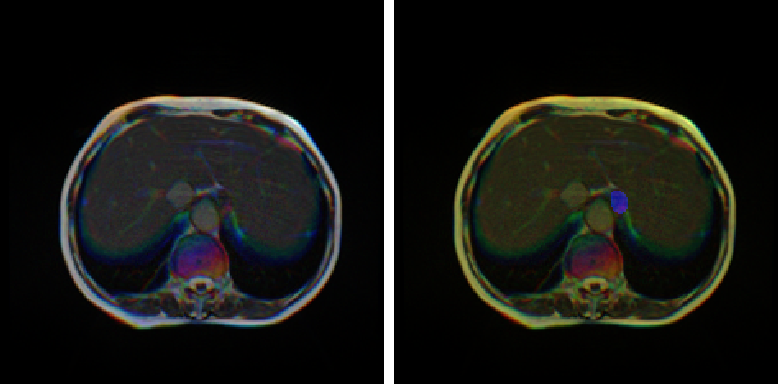

(266, 266, 1.5, 1.5)

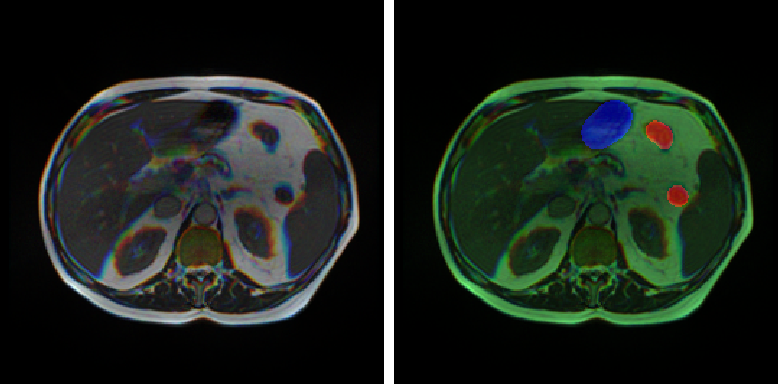

(276, 276, 1.63, 1.63)

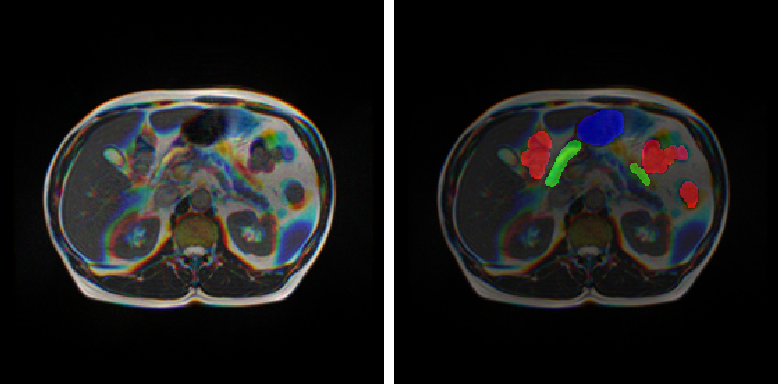

(360, 310, 1.5, 1.5)

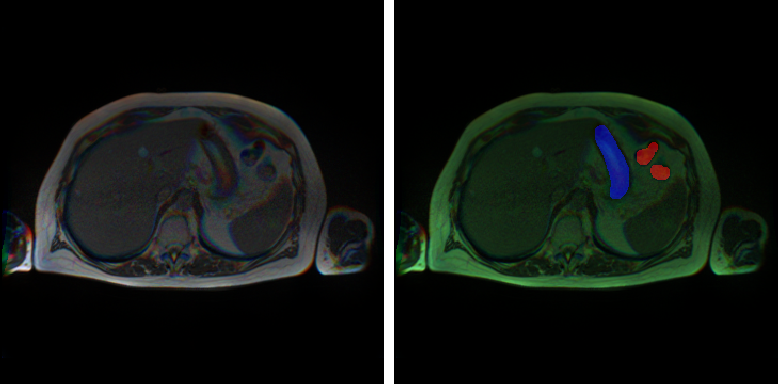

In [21]:
# import albumentations as A
np.random.seed(2022)
print(df_train[["size_x", "size_y", "spacing_x", "spacing_y"]].value_counts())
for info, group in df_train.groupby(["size_x", "size_y", "spacing_x", "spacing_y"]):
    print(info)
    file_name = np.random.choice(group.loc[group.slice == 60, "image_files"])
    img = display_pre(file_name, SIZE)
    display(Image.fromarray(img))

In [22]:
def show(idx):
    file_name = df_train.loc[idx, "image_files"]
    segms = df_train.loc[df_train.image_files == file_name]
    size = (segms.size_y.iloc[0], segms.size_x.iloc[0])
    print(file_name,size)
    img = display_pre(file_name, SIZE)
    display(Image.fromarray(img))

@interact
def f(idx = (0, len(df_train) - 1, 3)):
    show(idx)

interactive(children=(IntSlider(value=57741, description='idx', max=115487, step=3), Output()), _dom_classes=(…

In [23]:
import os
os.makedirs('/root/autodl-tmp/mmseg_train_n_384/images')
os.makedirs('/root/autodl-tmp/mmseg_train_n_384/labels')
os.makedirs('/root/autodl-tmp/mmseg_train_n_384/splits')

In [24]:
for day, group in tqdm(df_train.groupby("days")):
#     patient = group.patient.iloc[0]
    imgs = []
    msks = []
    for file_name in group.image_files.unique():
        segms = group.loc[group.image_files == file_name]
        ori_shape = (segms.size_y.iloc[0], segms.size_x.iloc[0])
        img_paths = segms.image_paths.iloc[0]
        img = np.zeros((*ori_shape, len(img_paths)), dtype=np.uint16)
        for i, img_path in enumerate(img_paths):
            image,old_shape = load_img(img_path, SIZE)
            img[..., i] = image
#         new_shape = img.shape[:2]
        masks = np.zeros(img.shape, dtype=np.uint8)
        for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
            cdf = segms[segms['class']==class_]
            rle = cdf.segmentation.squeeze()
            if len(cdf) and not pd.isna(rle):
                masks[..., i] = rle_decode(rle, ori_shape, SIZE)
        img, masks = rescale(img, masks, old_shape, SIZE)
        imgs.append(img)
        msks.append(masks)
    imgs = np.stack(imgs, 0)
    msks = np.stack(msks, 0)
    for i in range(msks.shape[0]):
        img = imgs[i]
        msk = msks[i]
        new_image_name = f"{day}_{i}.png"
        cv2.imwrite(f"/root/autodl-tmp/mmseg_train_n_384/images/{new_image_name}", img, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        cv2.imwrite(f"/root/autodl-tmp/mmseg_train_n_384/labels/{new_image_name}", msk, [cv2.IMWRITE_PNG_COMPRESSION, 0])

  0%|          | 0/274 [00:00<?, ?it/s]

In [ ]:
all_image_files = glob.glob("/root/autodl-tmp/mmseg_train_n_360/labels/*")
masks = []
for i in range(len(all_image_files)):
    mask = cv2.imread(all_image_files[i])
    if mask.sum()==0:
        masks.append(0)
    else:
        masks.append(1)
patients = [os.path.basename(_).split("_")[0] for _ in all_image_files]

from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
ctz = np.zeros(10)
cto = np.zeros(10)
split = list(StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=2022).split(patients, masks, groups=patients))
for fold, (train_idx, valid_idx) in enumerate(split):
    for i in valid_idx:
        if masks[i]==0:
            ctz[fold]+=1
        else:
            cto[fold]+=1
    with open(f"/root/autodl-tmp/mmseg_train_n_360/splits/fold_{fold}.txt", "w") as f:
        for idx in train_idx:
            f.write(os.path.basename(all_image_files[idx])[:-4] + "\n")
    with open(f"/root/autodl-tmp/mmseg_train_n_360/splits/valid_{fold}.txt", "w") as f:
        for idx in valid_idx:
            f.write(os.path.basename(all_image_files[idx])[:-4] + "\n")

In [ ]:
print(ctz)
print(cto)

### train all

In [25]:
all_image_files = glob.glob("/root/autodl-tmp/mmseg_train_n_384/labels/*")
masks = []
with open(f"/root/autodl-tmp/mmseg_train_n_384/splits/train_all.txt", "w") as f:
    for i in range(len(all_image_files)):
        f.write(os.path.basename(all_image_files[i])[:-4] + "\n")